<a href="https://colab.research.google.com/github/gupta24789/seq2seq/blob/main/seq2seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation :  German to English

In [ ]:
# !pip install evaluate
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [ ]:
import shutil
import random
import itertools
import spacy
import pandas as pd
import numpy as np
from pprint import pprint
from tqdm import tqdm , tqdm_notebook

import matplotlib.pyplot as plt
import evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

## Set Seed

In [ ]:
seed = 121
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Read Data

In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/seq2seq/main/data/train.csv")
val_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/seq2seq/main/data/val.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/seq2seq/main/data/test.csv")

train_df.shape, val_df.shape, test_df.shape

((29000, 2), (1014, 2), (1000, 2))

In [ ]:
train_df.head(3)

,en,de
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...


## Tokenizer

In [ ]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [ ]:
string = "What a lovely day it is today!"
[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

## Prepare data

In [ ]:
def tokenized_text(text, nlp, is_lower = True):
    if is_lower:
        text = str(text).lower()
    tokens = [token.text for token in nlp.tokenizer(text)]
    return tokens

In [ ]:
## train
train_df['en_tokens'] = train_df.en.map(lambda x: tokenized_text(x, en_nlp))
train_df['de_tokens'] = train_df.de.map(lambda x: tokenized_text(x, de_nlp))
## val
val_df['en_tokens'] = val_df.en.map(lambda x: tokenized_text(x, en_nlp))
val_df['de_tokens'] = val_df.de.map(lambda x: tokenized_text(x, de_nlp))
## test
test_df['en_tokens'] = test_df.en.map(lambda x: tokenized_text(x, en_nlp))
test_df['de_tokens'] = test_df.de.map(lambda x: tokenized_text(x, de_nlp))

In [ ]:
train_df.head(3)

,en,de,en_tokens,de_tokens
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...,"[two, young, ,, white, males, are, outside, ne...","[zwei, junge, weiße, männer, sind, im, freien,..."
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...,"[several, men, in, hard, hats, are, operating,...","[mehrere, männer, mit, schutzhelmen, bedienen,..."
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...,"[a, little, girl, climbing, into, a, wooden, p...","[ein, kleines, mädchen, klettert, in, ein, spi..."


## Build Vocab

In [ ]:
special_words = ["<unk>","<pad>", "<sos>","<eos>"]
en_words = list(set(itertools.chain.from_iterable(train_df.en_tokens.tolist())))
de_words = list(set(itertools.chain.from_iterable(train_df.de_tokens.tolist())))

en_words = special_words + en_words
de_words = special_words + de_words

en_vocab = {w:i for i,w in enumerate(en_words)}
de_vocab = {w:i for i,w in enumerate(de_words)}

UNK_ID = en_vocab['<unk>']
PAD_ID = en_vocab['<pad>']
SOS_ID = en_vocab['<sos>']
EOS_ID = en_vocab['<eos>']

print(f"en_vocab : {len(en_vocab)}")
print(f"de_vocab : {len(de_vocab)}")

en_vocab : 9795
de_vocab : 18669


## Encode text

In [ ]:
def encode_tokens(tokens, vocab):
    encoded = []
    for w in tokens:
        encoded.append(vocab.get(w, UNK_ID))
    ## adding SOS & EOS
    encoded = [SOS_ID] + encoded + [EOS_ID]
    return encoded

In [ ]:
## train
train_df['en_encoded'] = train_df.en_tokens.apply(lambda x: encode_tokens(x, en_vocab))
train_df['de_encoded'] = train_df.de_tokens.apply(lambda x: encode_tokens(x, de_vocab))
## val
val_df['en_encoded'] = val_df.en_tokens.apply(lambda x: encode_tokens(x, en_vocab))
val_df['de_encoded'] = val_df.de_tokens.apply(lambda x: encode_tokens(x, de_vocab))
## test
test_df['en_encoded'] = test_df.en_tokens.apply(lambda x: encode_tokens(x, en_vocab))
test_df['de_encoded'] = test_df.de_tokens.apply(lambda x: encode_tokens(x, de_vocab))

In [ ]:
train_df.head(3)

,en,de,en_tokens,de_tokens,en_encoded,de_encoded
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...,"[two, young, ,, white, males, are, outside, ne...","[zwei, junge, weiße, männer, sind, im, freien,...","[2, 5541, 9748, 8668, 7232, 8020, 7823, 8151, ...","[2, 2385, 11534, 14627, 3930, 14243, 13553, 53..."
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...,"[several, men, in, hard, hats, are, operating,...","[mehrere, männer, mit, schutzhelmen, bedienen,...","[2, 1284, 5992, 1851, 9535, 2874, 7823, 3462, ...","[2, 14301, 3930, 12728, 1589, 2399, 283, 6457,..."
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...,"[a, little, girl, climbing, into, a, wooden, p...","[ein, kleines, mädchen, klettert, in, ein, spi...","[2, 7839, 5797, 7125, 2508, 2498, 7839, 5052, ...","[2, 283, 5511, 2398, 11884, 3497, 283, 4337, 1..."


## Data Loaders

In [ ]:
train_data = train_df[['en_encoded','de_encoded']].to_dict('records')
val_data = val_df[['en_encoded','de_encoded']].to_dict('records')
test_data = test_df[['en_encoded','de_encoded']].to_dict('records')

In [ ]:
pprint(train_data[:2], compact=True)

[{'de_encoded': [2, 2385, 11534, 14627, 3930, 14243, 13553, 5325, 3497, 4550,
                 5601, 4632, 8111, 5154, 3],
  'en_encoded': [2, 5541, 9748, 8668, 7232, 8020, 7823, 8151, 3040, 1491, 6715,
                 2734, 3]},
 {'de_encoded': [2, 14301, 3930, 12728, 1589, 2399, 283, 6457, 5154, 3],
  'en_encoded': [2, 1284, 5992, 1851, 9535, 2874, 7823, 3462, 7839, 1938, 164,
                 7192, 2734, 3]}]


In [ ]:
def custom_collate(batch):
    """
    Dynamic padding : find the max len in the batch and do the padding
    """
    en_batch = [torch.tensor(item['en_encoded']) for item in batch]
    de_batch = [torch.tensor(item['de_encoded']) for item in batch]

    padded_en = nn.utils.rnn.pad_sequence(en_batch, batch_first= True, padding_value= PAD_ID)
    padded_de = nn.utils.rnn.pad_sequence(de_batch, batch_first= True, padding_value= PAD_ID)

    return {"padded_en": padded_en, "padded_de":  padded_de}

In [ ]:
batch_size = 3
train_dl = DataLoader(train_data , batch_size = batch_size, shuffle = False, collate_fn= custom_collate)
example = next(iter(train_dl))
padded_en, padded_de = example['padded_en'],example['padded_de']
print(padded_en.shape, padded_de.shape)

torch.Size([3, 14]) torch.Size([3, 15])


In [ ]:
padded_en

tensor([[   2, 5541, 9748, 8668, 7232, 8020, 7823, 8151, 3040, 1491, 6715, 2734,
            3,    1],
        [   2, 1284, 5992, 1851, 9535, 2874, 7823, 3462, 7839, 1938,  164, 7192,
         2734,    3],
        [   2, 7839, 5797, 7125, 2508, 2498, 7839, 5052, 5598, 2734,    3,    1,
            1,    1]])

In [ ]:
padded_de

tensor([[    2,  2385, 11534, 14627,  3930, 14243, 13553,  5325,  3497,  4550,
          5601,  4632,  8111,  5154,     3],
        [    2, 14301,  3930, 12728,  1589,  2399,   283,  6457,  5154,     3,
             1,     1,     1,     1,     1],
        [    2,   283,  5511,  2398, 11884,  3497,   283,  4337,  1523,  1491,
          5154,     3,     1,     1,     1]])

In [ ]:
## dataloaders
batch_size = 512
train_dl = DataLoader(train_data , batch_size = batch_size, shuffle = True, collate_fn= custom_collate)
val_dl = DataLoader(val_data , batch_size = batch_size, shuffle = False, collate_fn= custom_collate)
test_dl = DataLoader(test_data , batch_size = batch_size, shuffle = False, collate_fn= custom_collate)

## Building Model

In [ ]:
class Encoder(nn.Module):
    """
    Encode German text
    """
    def __init__(self, vocab_size, emb_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, n_layers, bidirectional):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, encoder_hidden_dim, dropout=dropout, num_layers = n_layers, bidirectional = bidirectional, batch_first= True)
        self.linear = nn.Linear(encoder_hidden_dim * 2 if bidirectional else encoder_hidden_dim, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, batch, verbose = False):
        # batch : [batch size, sent len]
        embedded = self.dropout(self.embedding(batch))
        # embedded : [batch size, sent len , emb dim]
        output, hidden = self.rnn(embedded)
        # output : [batch size, sent len, hidden dim * num directions]
        # hidden : [n_layers * num directions, batch size, sent len]

        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN

        combined_hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        final_hidden = torch.tanh(self.linear(combined_hidden))

        if verbose:
            print(f'input : {batch.shape}')
            print(f'embedded : {embedded.shape}')
            print(f'output : {output.shape}')
            print(f'hidden : {hidden.shape}')
            print(f'combined_hidden : {combined_hidden.shape}')
            print(f'final_hidden : {final_hidden.shape}')

        return output, final_hidden

In [ ]:
## Config
encoder_bidirectional = True
encoder_hidden_dim = 32
decoder_hidden_dim = 128

In [ ]:
## Enoder
encoder = Encoder(vocab_size = len(de_vocab), emb_dim = 100, encoder_hidden_dim=encoder_hidden_dim,
                  decoder_hidden_dim = decoder_hidden_dim,
                  dropout=0.1, n_layers= 2, bidirectional= encoder_bidirectional)
output, hidden = encoder(padded_de, verbose = True)

input : torch.Size([3, 15])
embedded : torch.Size([3, 15, 100])
output : torch.Size([3, 15, 64])
hidden : torch.Size([4, 3, 32])
combined_hidden : torch.Size([3, 64])
final_hidden : torch.Size([3, 128])


In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim, encoder_bidirectional):
        super().__init__()
        self.attn_fc = nn.Linear((encoder_hidden_dim * 2 if encoder_bidirectional else encoder_hidden_dim) + decoder_hidden_dim, decoder_hidden_dim)
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * encoder num direction]
        batch_size, src_length = encoder_outputs.shape[0], encoder_outputs.shape[1]

        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * encoder num direction]
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, encoder_hidden_dim,decoder_hidden_dim, dropout, attention, encoder_bidirectional):
        super().__init__()
        self.vocab_size = vocab_size
        self.attention = attention
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2 if encoder_bidirectional else encoder_hidden_dim) + emb_dim, decoder_hidden_dim, dropout=dropout, batch_first= True)
        self.fc_out = nn.Linear((encoder_hidden_dim * 2 if encoder_bidirectional else encoder_hidden_dim) + decoder_hidden_dim + emb_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):

        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * encoder num direction]
        # print(f'hidden : {hidden.shape}')
        # print(f'encoder_outputs : {encoder_outputs.shape}')

        input = input.unsqueeze(1)
        # input = [batch size, 1]
        # print(f'input : {input.shape}')

        embedded = self.dropout(self.embedding(input))
        # embedded = [batch size, 1, embedding dim]
        # print(f'embedded : {embedded.shape}')

        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(dim = 1)
        # a = [batch size, 1, src length]
        # print(f'a : {a.shape}')


        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * encoder n_direction]
        # print(f'weighted : {weighted.shape}')


        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [batch size, 1, (encoder hidden dim * encoder n_direction) + embedding dim]
        # print(f'rnn_input : {rnn_input.shape}')


        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden

        # print(f'output : {output.shape}')
        # print(f'hidden : {hidden.shape}')

        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)

        # print(f'embedded : {embedded.shape}')
        # print(f'weighted : {weighted.shape}')
        # print(f'output : {output.shape}')

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        # print(f'prediction : {prediction.shape}')
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
## Decoder
## de[:,0] -> first input
attention = Attention(encoder_hidden_dim, decoder_hidden_dim, encoder_bidirectional = encoder_bidirectional)
decoder = Decoder(vocab_size = len(en_vocab),
                  emb_dim = 100,
                  encoder_hidden_dim = encoder_hidden_dim,
                  decoder_hidden_dim = decoder_hidden_dim,
                  dropout = 0.1,
                  attention = attention,
                  encoder_bidirectional = encoder_bidirectional)
prediction, hidden, a = decoder(padded_en[:,0], hidden, output)
print(prediction.shape, hidden.shape, a.shape)

torch.Size([3, 9795]) torch.Size([3, 128]) torch.Size([3, 15])


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [batch size, sent len]
        # trg = [batch size, sent len]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[0]
        trg_length = trg.shape[1]
        trg_vocab_size = self.decoder.vocab_size
        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size,trg_length,trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[:,0]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            output = output.squeeze(dim = 1)
            outputs[:,t,:] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[:,t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [ ]:
model = Seq2Seq(encoder, decoder, device = "cpu")
outputs = model(padded_de, padded_en, teacher_forcing_ratio = True)
print(outputs.shape)

torch.Size([3, 14, 9795])


## Training

In [ ]:
class Seq2SeqLightningModel(pl.LightningModule):

    def __init__(self, encode, decoder, learning_rate, device, teacher_forcing_ratio):
        super().__init__()
        self.learning_rate = learning_rate
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.encoder = encoder
        self.decoder = decoder
        self.seq2seq_model = Seq2Seq(self.encoder, self.decoder, device)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_ID)
        self.init_weights()

        self.train_loss = []
        self.val_loss = []
        self.test_loss = []

    def init_weights(self):
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.01)

    def forward(self, de, en):
        logits = self.seq2seq_model(de, en, teacher_forcing_ratio = self.teacher_forcing_ratio)
        return logits

    def training_step(self, batch):
        src, trg = batch['padded_de'], batch['padded_en']
        output = self(src, trg)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        # print(output.shape, trg.shape)
        loss = self.loss_fn(output, trg)
        self.train_loss.append(loss.item())
        self.log_dict({"train_loss": loss}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch):
        src, trg = batch['padded_de'], batch['padded_en']
        output = self(src, trg)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = self.loss_fn(output, trg)
        self.val_loss.append(loss.item())
        self.log_dict({"val_loss": loss}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        print(f"Epoch : {self.current_epoch}  \
              Train Loss : {np.mean(self.train_loss)} \
              Val Loss : {np.mean(self.val_loss)} \
              Train PPL : {np.exp(np.mean(self.train_loss))} \
              Val PPL : {np.exp(np.mean(self.val_loss))} ")

        self.train_loss =[]
        self.val_loss =[]


    def test_step(self, batch):
        src, trg = batch['padded_de'], batch['padded_en']
        output = self(src, trg)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = self.loss_fn(output, trg)
        self.test_loss.append(loss.item())
        return loss

    def on_test_epoch_end(self) -> None:
        print(f"Test Loss : {np.mean(self.test_loss)}  Test PPL : {np.exp(np.mean(self.test_loss))}")
        self.test_loss = []

    def configure_optimizers(self):
        opt = optim.Adam(self.parameters(), lr = self.learning_rate)
        return opt

In [ ]:
# ## test architecture
# encoder = Encoder(vocab_size = len(de_vocab), emb_dim = 100, encoder_hidden_dim=encoder_hidden_dim,
#                   decoder_hidden_dim = decoder_hidden_dim,
#                   dropout=0.1, n_layers= 2, bidirectional= encoder_bidirectional)
# attention = Attention(encoder_hidden_dim, decoder_hidden_dim, encoder_bidirectional = encoder_bidirectional)
# decoder = Decoder(vocab_size = len(en_vocab),
#                   emb_dim = 100,
#                   encoder_hidden_dim = encoder_hidden_dim,
#                   decoder_hidden_dim = decoder_hidden_dim,
#                   dropout = 0.1,
#                   attention = attention,
#                   encoder_bidirectional = encoder_bidirectional)
# model = Seq2SeqLightningModel(encoder, decoder, learning_rate= .001, device ="cpu", teacher_forcing_ratio=0.5)
# outputs = model(padded_de, padded_en)
# outputs.shape

In [ ]:
## clear old checkpoints
checkpoints_dir = "checkpoints_logs"
if os.path.exists(checkpoints_dir):
    shutil.rmtree(checkpoints_dir)

## CONFIG
n_layers = 2
encoder_bidirectional = True
encoder_emb_dim = 256
decoder_emb_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5


## Model Training
encoder = Encoder(vocab_size = len(de_vocab),
                  emb_dim = encoder_emb_dim,
                  encoder_hidden_dim=encoder_hidden_dim,
                  decoder_hidden_dim = decoder_hidden_dim,
                  dropout=0.1,
                  n_layers= 2,
                  bidirectional= encoder_bidirectional)

attention = Attention(encoder_hidden_dim, decoder_hidden_dim, encoder_bidirectional = encoder_bidirectional)

decoder = Decoder(vocab_size = len(en_vocab),
                  emb_dim = decoder_emb_dim,
                  encoder_hidden_dim = encoder_hidden_dim,
                  decoder_hidden_dim = decoder_hidden_dim,
                  dropout = 0.1,
                  attention = attention,
                  encoder_bidirectional = encoder_bidirectional)
model = Seq2SeqLightningModel(encoder, decoder, learning_rate= .001, device ="cuda", teacher_forcing_ratio=0.5)

callbacks = pl.callbacks.ModelCheckpoint(dirpath = checkpoints_dir,
                                         filename = '{epoch}-{val_loss:.2f}',
                                          mode = "min",
                                          monitor = "val_loss",
                                          save_last = True,
                                          save_top_k=-1)


trainer = pl.Trainer(accelerator= "gpu",
           max_epochs=10,
           check_val_every_n_epoch = 2,
           gradient_clip_val=1,
           gradient_clip_algorithm="value",
           callbacks = [callbacks])

trainer.fit(model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | Encoder          | 12.4 M
1 | decoder       | Decoder          | 23.6 M
2 | seq2seq_model | Seq2Seq          | 36.0 M
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
36.0 M    Trainable params
0         Non-trainable params
36.0 M    Total params
144.029   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch : 0                Train Loss : nan               Val Loss : 9.1892991065979               Train PPL : nan               Val PPL : 9791.785575621763 


/home/saurabh/anaconda3/envs/lighting/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/saurabh/anaconda3/envs/lighting/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/saurabh/anaconda3/envs/lighting/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch : 1                Train Loss : 5.5035089317121               Val Loss : 4.889101982116699               Train PPL : 245.55204770569037               Val PPL : 132.83423295737433 


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch : 3                Train Loss : 4.601984998636079               Val Loss : 4.404259443283081               Train PPL : 99.68198799756638               Val PPL : 81.7985439463234 


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch : 5                Train Loss : 4.148892768642359               Val Loss : 4.072455883026123               Train PPL : 63.363803053319536               Val PPL : 58.7009483761357 


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch : 7                Train Loss : 3.595691781294973               Val Loss : 3.7953226566314697               Train PPL : 36.44090040355712               Val PPL : 44.49258991896468 


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch : 9                Train Loss : 3.042349675245452               Val Loss : 3.8322120904922485               Train PPL : 20.954421521497498               Val PPL : 46.16454552016852 


`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
## if test dataset has loss near around val loss that means we are not overfitting
model = model.eval()
trainer.test(model, dataloaders= test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/home/saurabh/anaconda3/envs/lighting/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test Loss : 3.358778476715088  Test PPL : 28.7540456819384


[{}]

## Predict

In [ ]:
en_vocab_lookup = {i:w for w,i in en_vocab.items()}

def translate_sentence(sentence,model,en_nlp,de_nlp,en_vocab,de_vocab,lower,sos_token,eos_token,device,max_output_length=25):
    model.eval()
    with torch.no_grad():
        de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]

        ids = [de_vocab.get(token, UNK_ID) for token in de_tokens]
        tensor = torch.LongTensor(ids).unsqueeze(0).to(device)
        encoder_outputs, hidden = model.encoder(tensor)


        inputs = [en_vocab.get(sos_token)]
        attentions = torch.zeros(max_output_length, 1, len(ids))

        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)

            # print(f'input tensor : {inputs_tensor.shape}')
            # print(f'hidden : {hidden.shape}')
            # print(f'encoder output : {encoder_outputs.shape}')

            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break

        en_tokens = [en_vocab_lookup.get(i) for i in inputs]
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

In [ ]:
sentence = test_df.iloc[0]['de']
expected_translation = test_df.iloc[0]['en']
print(sentence)
print(expected_translation)

Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
A man in an orange hat starring at something.


In [ ]:
translation, sentence_tokens, attention = translate_sentence(sentence,model,en_nlp,de_nlp,en_vocab,de_vocab,lower = True,sos_token = "<sos>",eos_token = "<eos>",device = "cuda")

In [ ]:
print("Pred : ", translation)
print("True : ", sentence_tokens)

Pred :  ['<sos>', 'a', 'man', 'in', 'an', 'orange', 'hat', 'is', 'a', 'a', '.', '<eos>']
True :  ['<sos>', 'ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.', '<eos>']


In [ ]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

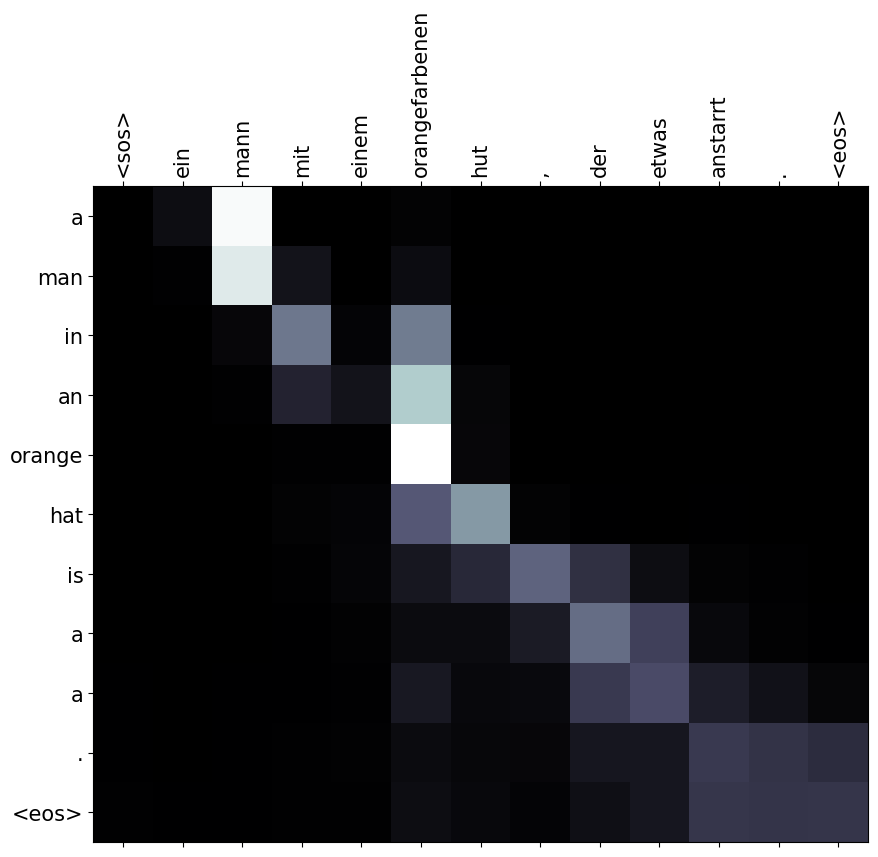

In [ ]:
plot_attention(sentence_tokens, translation, attention)

## Blue Scroe

In [ ]:
translations = [translate_sentence(sent,model,en_nlp,de_nlp,en_vocab,de_vocab,lower = True,sos_token = "<sos>",eos_token = "<eos>",device = "cuda")[0] for sent in tqdm_notebook(test_df.de.values)]

/tmp/ipykernel_24154/4149176577.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  translations = [translate_sentence(sent,model,en_nlp,de_nlp,en_vocab,de_vocab,lower = True,sos_token = "<sos>",eos_token = "<eos>",device = "cuda")[0] for sent in tqdm_notebook(test_df.de.values)]


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
predictions = [" ".join(translation[1:-1]) for translation in translations]
print(predictions[:2])

['a man in an orange hat is a a .', 'a tri - dog runs along the grass in front of a white dog .']


In [ ]:
references = test_df.en.str.lower().tolist()
pprint(references[:2], compact=True)

['a man in an orange hat starring at something.',
 'a boston terrier is running on lush green grass in front of a white fence.']


In [ ]:
bleu = evaluate.load("bleu")

In [ ]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(en_nlp,  lower = True)

In [ ]:
results = bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)
results

{'bleu': 0.2091149147336781,
 'precisions': [0.5317575406032483,
  0.27517198248905567,
  0.1503561736770692,
  0.0869162342475908],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0561298721188452,
 'translation_length': 13792,
 'reference_length': 13059}